In [1]:
import torch
import torch.distributions as dist

import numpy as np
import pandas as pd

from tqdm.auto import trange

from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt
from matplotlib import cm, patches, animation

# sklearn implementation of GMM
from sklearn.mixture import GaussianMixture

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm 

SEED = 13

np.random.seed(SEED)
torch.manual_seed(SEED)
CMAP = plt.cm.get_cmap("Dark2", 8)

### Gaussian Mixture Models from scratch

In [2]:
class GaussianMixtureModelNd:
    distribution = dist.MultivariateNormal
    def __init__(
        self,
        n_components: int, 
        n_epochs: int = 50,
        dim: int = 2,
        termination_threshold: float = 1e-3, 
        verbose: bool = True
    ):
        """Inicjalizacja modelu dwuwymiarowego.
        
        :param n_components: number of model's component
        :param n_epochs: number of training epochs
        :param termination_threshold: log likelihood increment threshold
        :param verbose: show training logs
        """
        self.history = {
            "means": [],
            "covariances": [],
            "mixing_coefs": [],
            "log_likelihood": []
        }
        
        self.n_components = n_components
        self.n_epochs = n_epochs
        self.dim = dim
        self.termination_threshold = termination_threshold
        self.verbose = verbose
        
        self.means = torch.rand((self.n_components, self.dim))
        self.covariances = torch.eye(self.dim).repeat(
            self.n_components, 1, 1
        )
        self.mixing_coefs = torch.full(
            (self.n_components,),
            fill_value=1 / self.n_components
        )
        
    def expectation_step(self, x: torch.Tensor) -> torch.Tensor:
        """Expectation Step (count responsibilities)."""
        responsibilities = []
        resp = []
        
        for k in range(self.n_components):
            resp.append(self.mixing_coefs[k] * torch.exp(self.distribution(self.means[k],
                                                                           scale_tril=torch.tril(self.covariances[k])).log_prob(x)))
        
        resp = torch.stack(resp)
        resp = resp / resp.sum(axis=0, keepdims=True)
        resp = torch.tensor(resp, dtype=torch.float32)
        
        return resp.T
    
    def maximization_step(
        self, x: torch.Tensor, responsibilities: torch.Tensor
    ):
        """Maximization Step (count parametrów)."""
        N_k = responsibilities.sum(axis=0)
        N = x.size()[0]
        mixing_coefs = N_k / N
        
        
        covariances = []
        for k in range(self.n_components):
            r = responsibilities[:, k]
            var = x - self.means[k]
            covariances.append(r * var.T @ var /  N_k[k])
        covariances = torch.stack(covariances)
       
        means = []
        for k in range(self.n_components):
            r = responsibilities[:, k]
            means.append(r @ x / N_k[k])
        means = torch.stack(means)
        
        self.means = means
        self.covariances = covariances
        self.mixing_coefs = mixing_coefs
        
        
    def loglikelihood(self, x: torch.Tensor) -> float:
        avg_logprob = 0
        for x_n in x:
            log_prob = 0
            for k in range(self.n_components):
                log_prob += self.mixing_coefs[k] * torch.exp(self.distribution(self.means[k],
                                                                        scale_tril=torch.tril(self.covariances[k])).log_prob(x_n))
                #log_prob += self.mixing_coefs[k] * multivariate_normal.pdf(x_n, self.means[k], self.covariances[k])
            avg_logprob += torch.log(log_prob)
        
        return avg_logprob
        
    def update_history(self, x: torch.Tensor):
        """Aktualizacja logu."""
        self.history["means"].append(self.means)
        self.history["covariances"].append(self.covariances)
        self.history["mixing_coefs"].append(self.mixing_coefs)
        self.history["log_likelihood"].append(self.loglikelihood(x))
    
    def fit(self, x: torch.Tensor) -> float:
        """Trenowanie modelu."""
        self.update_history(x)
        for epoch in trange(self.n_epochs):
            responsibilities = self.expectation_step(x)
            self.maximization_step(x, responsibilities)
            self.update_history(x)
            if (
                self.history["log_likelihood"][-1] - self.history["log_likelihood"][-2] 
                < self.termination_threshold
            ):
                print("Log likelihood not increasing, stopping.")
                self.n_epochs = epoch
                break
        
        if self.verbose:
            self._plot_training()
        
    def predict(self, x: torch.Tensor) -> torch.Tensor:
        """Predykcja posterior dla każdego z komponentów."""
        prediction = [] 
        for x_n in x:
            arr = []
            for k in range(self.n_components):
                arr.append(self.distribution(self.means[k], 
                                                       scale_tril=torch.tril(self.covariances[k])).log_prob(x_n))
            prediction.append(arr.index(max(arr)))
        return prediction
        
    def _plot_training(self):
        """Wizualizacja uczenia."""
        fig, ax = plt.subplots()
        ax.plot(self.history["log_likelihood"])
        ax.set_xlabel("Epoka")
        ax.set_ylabel("Log likelihood")
        plt.show()
        
    def animation(self, x: torch.Tensor):
        """Animacja uczenia modelu."""
        fig, axes = visualize(points=x.numpy())
        anim = animation.FuncAnimation(
            fig=fig,
            func=lambda i: visualize(
                points=x.numpy(),
                gaussians=[
                    (mu, sigma, pi)
                    for mu, sigma, pi 
                    in zip(
                        self.history["means"][i].numpy(),
                        self.history["covariances"][i].numpy(),
                        self.history["mixing_coefs"][i].numpy(),
                    )
                ],
                fig=fig
            ), 
            frames=range(0, self.n_epochs, 5 if self.n_epochs > 10 else 1), 
            interval=500,
            blit=False
        )
        plt.close()
        return anim.to_jshtml()
    
    def sample(
        self, sample_shape: torch.Size = torch.Size([])
    ) -> torch.Tensor:
        """Sample from mixture model"""
        m = dist.Categorical(self.mixing_coefs)
        sample = m.sample()
        distribution = self.distribution(self.means[sample], self.covariances[sample])
    
        return distribution.sample().numpy()

### Load data

In [3]:
def train_test_dataset(dataset_path, from_column=1, to_column=10):
    dataset = pd.read_csv(dataset_path)
    dataset_train = dataset[dataset.Usage=='Train']
    dataset_train = dataset_train.drop("Usage", axis = 1)
    dataset_test = dataset[dataset.Usage=='Test']
    dataset_test = dataset_test.drop("Usage", axis = 1)
    #X_train = dataset_train.iloc[:,1:-1].to_numpy()
    #X_test = dataset_test.iloc[:,1:-1].to_numpy()
    X_train = dataset_train.iloc[:,from_column:to_column].to_numpy()
    X_test = dataset_test.iloc[:,from_column:to_column].to_numpy()
    X_train = torch.from_numpy(X_train).float()
    X_test = torch.from_numpy(X_test).float()
    y_train = dataset_train.iloc[:,-1:].to_numpy()
    y_test = dataset_test.iloc[:,-1:].to_numpy()
    return X_train, y_train, X_test, y_test

# Tests

* Compare results using AIK (Akaike Information Criterion )
* Implementation from scratch handle up to 15 dimensional input
* Test different configurations for the input

In [4]:
def aic(x: torch.Tensor, model: GaussianMixtureModelNd) -> float:
    """AIC for data and model parameters."""
    M = 3 * model.n_components
    max_log = torch.max(model.loglikelihood(x))
    return float(max_log-M)

def bic(x: torch.Tensor, model: GaussianMixtureModelNd) -> float:
    """BIC for data and model parameters."""
    N = len(x)
    M = 3 * model.n_components
    max_log = torch.max(model.loglikelihood(x))
    return float(max_log - 0.5*M * np.log(N))

In [5]:
pca = PCA(n_components=2)

def pca_transformation(X):
    principalComponents = pca.fit_transform(X)
    principalDf = pd.DataFrame(data = principalComponents, 
                               columns = ['principal component 1', 'principal component 2'])
    
    return principalDf

In [6]:
def plot_components(model, n_components, X_train, y_train, X_test, y_test, y_pred):
    
    # PCA transformation
    principalDf_Train = pca_transformation(X_train)
    principalDf_Test = pca_transformation(X_test)
    
    # Concatenate features with labels
    y = []
    for i in y_train:
        i_str = str(i)
        y.append(i_str[2:-2])

    df = pd.DataFrame()
    df['target'] = y
    finalDf = pd.concat([principalDf_Train, df[['target']]], axis = 1)
    
    fig = plt.figure(figsize = (10,10))
    
    # Plot Train
    ax1 = fig.add_subplot(221) 
    ax1.set_xlabel('Principal Component 1', fontsize = 15)
    ax1.set_ylabel('Principal Component 2', fontsize = 15)
    ax1.set_title('Real components', fontsize = 20)

    targets = ['CL0', 'CL3', 'CL6']
    for target in targets:
        indicesToKeep = finalDf['target'] == target
        ax1.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
                   , finalDf.loc[indicesToKeep, 'principal component 2']
                   , s = 50)
    ax1.legend(targets)
    ax1.grid()
    
    # Plot Test
    y = []
    for i in y_test:
        i_str = str(i)
        y.append(i_str[2:-2])

    df = pd.DataFrame()
    df['target'] = y
    finalDf = pd.concat([principalDf_Test, df[['target']]], axis = 1)
    
    ax2 = fig.add_subplot(222) 
    ax2.set_xlabel('Principal Component 1', fontsize = 15)
    ax2.set_ylabel('Principal Component 2', fontsize = 15)
    ax2.set_title('Test components', fontsize = 20)

    targets = ['CL0', 'CL3', 'CL6']
    for target in targets:
        indicesToKeep = finalDf['target'] == target
        ax2.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
                   , finalDf.loc[indicesToKeep, 'principal component 2']
                   , s = 50)
    ax2.legend(targets)
    ax2.grid()
    
    
    # Plot Pred
    df = pd.DataFrame()
    df['target'] = y_pred
    finalDf = pd.concat([principalDf_Test, df[['target']]], axis = 1)

    ax3 = fig.add_subplot(223) 
    ax3.set_xlabel('Principal Component 1', fontsize = 15)
    ax3.set_ylabel('Principal Component 2', fontsize = 15)
    ax3.set_title('Pred components', fontsize = 20)

    color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
             '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    targets = range(n_components)
    for target in targets:
        indicesToKeep = finalDf['target'] == target
        ax3.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
                   , finalDf.loc[indicesToKeep, 'principal component 2'] 
                   , s = 10)

    plt.tight_layout()
    ax3.legend(targets)
    ax3.grid()

* First 12 columns descript the person
* The remaining columns refer to whether the person consumed stimulants or not

### Cannabis

In [7]:
X_train, y_train, X_test, y_test = train_test_dataset("data/cannabis_preprocessed.csv", 1, 13)

#### Analyze AIC and BIC to choose the best hyperparameters

In [76]:
dim = 12
index = 0
epochs = [10, 30, 50, 100]
components = [2, 3, 4, 5, 6, 7, 8, 9, 10]
epochs_df, aic_from_scratch, bic_from_scratch, aic_sklearn, bic_sklearn, df_components = [], [], [], [], [], []

for epoch in tqdm(epochs):
    for n_component in components:
        
        try:
            model = GaussianMixtureModelNd(n_component, n_epochs=epoch, dim=dim, verbose=False)
            model.fit(X_train)
            aic_from_scratch.append(aic(X_train, model))
            bic_from_scratch.append(bic(X_train, model))

            model = GaussianMixture(n_components=n_component, max_iter=epoch)
            model.fit(X_train)
            aic_sklearn.append(model.aic(X_train))
            bic_sklearn.append(model.bic(X_train))

            epochs_df.append(epoch)
            df_components.append(n_component)
            
        except:
            pass
    

  0%|          | 0/4 [00:00<?, ?it/s]

<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



/home/katarzyna/.local/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



/home/katarzyna/.local/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



/home/katarzyna/.local/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



/home/katarzyna/.local/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
 25%|██▌       | 1/4 [02:03<06:09, 123.22s/it]

<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



 50%|█████     | 2/4 [04:02<04:04, 122.05s/it]

<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



 75%|███████▌  | 3/4 [05:57<01:59, 119.96s/it]

<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



100%|██████████| 4/4 [07:41<00:00, 115.29s/it]


In [77]:
df = pd.DataFrame()

df["epoch"] = epochs_df
df['n_component'] = df_components
df["aic_from_scratch"] = aic_from_scratch
df["bic_from_scratch"] = bic_from_scratch

df["aic_sklearn"] = aic_sklearn
df["bic_sklearn"] = bic_sklearn

df.to_csv("results/cannabis_gmm.csv")

#### Best parameters for Sklearn

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [14]:
df_sklearn = df
df_sklearn = df_sklearn.drop('aic_from_scratch', axis=1)
df_sklearn = df_sklearn.drop('bic_from_scratch', axis=1)
df_sklearn.head()

,epoch,n_component,aic_sklearn,bic_sklearn
0,10,2,24119.050048,25057.467925
1,10,3,22392.031449,23802.250579
2,10,4,15480.087992,17362.108375
3,10,5,9107.986359,11461.807994
4,10,6,18580.182640,21405.805528


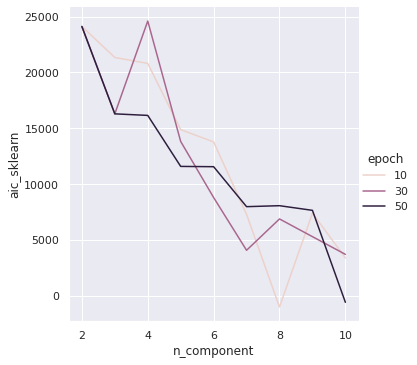

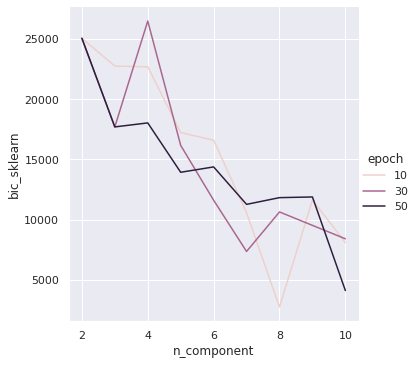

In [184]:
sns.relplot(
    data=df_sklearn, 
    kind="line",
    x="n_component", y="aic_sklearn", 
    hue="epoch"
)

sns.relplot(
    data=df_sklearn, 
    kind="line",
    x="n_component", y="bic_sklearn",
    hue="epoch"
)

In [20]:
df_sklearn.sort_values(by=['bic_sklearn', 'aic_sklearn'], inplace=True, ascending=False)
df_sklearn.head()

,epoch,n_component,aic_sklearn,bic_sklearn
0,10,2,24119.050048,25057.467925
9,30,2,24119.050048,25057.467925
17,50,2,24119.050048,25057.467925
25,100,2,24119.050048,25057.467925
1,10,3,22392.031449,23802.250579


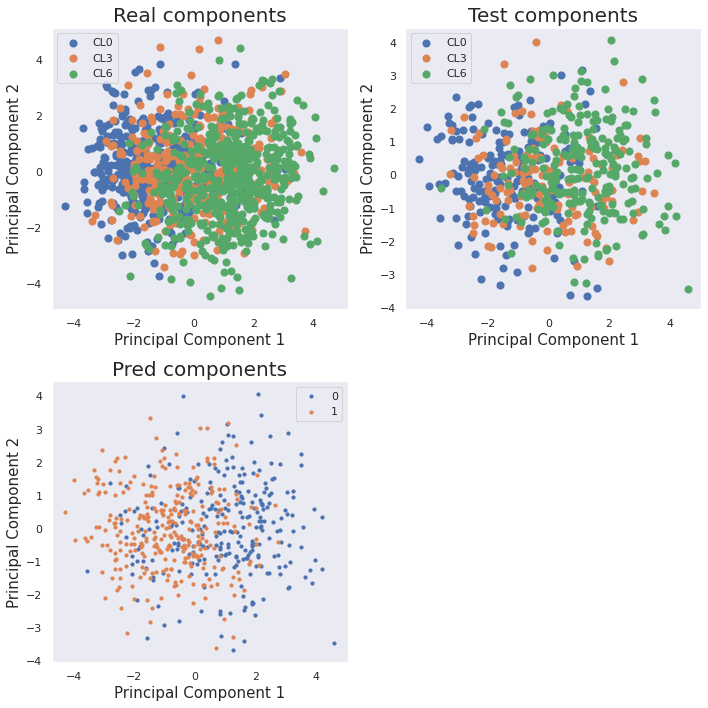

In [25]:
n_components = 2
epoch = 10
model = GaussianMixture(n_components=n_components, max_iter=epoch)
model.fit(X_train)
y_pred = model.predict(X_test)
plot_components(model, n_components, X_train, y_train, X_test, y_test, y_pred)

#### Best model parameters from scratch

In [21]:
df_scratch = df
df_scratch = df_scratch.drop('aic_sklearn', axis=1)
df_scratch = df_scratch.drop('bic_sklearn', axis=1)
df_scratch.head()

,epoch,n_component,aic_from_scratch,bic_from_scratch
8,10,10,-14951.427734,-15029.197266
14,30,7,-18284.490234,-18338.929688
20,50,5,-18764.498047,-18803.382812
12,30,5,-19125.005859,-19163.890625
30,100,10,-19377.001953,-19454.771484


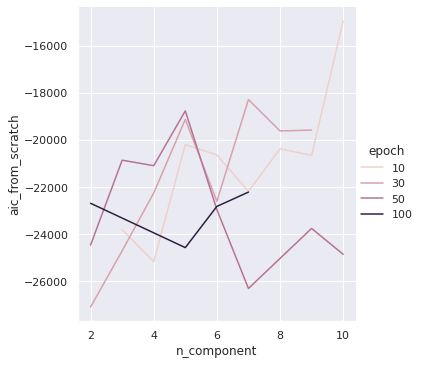

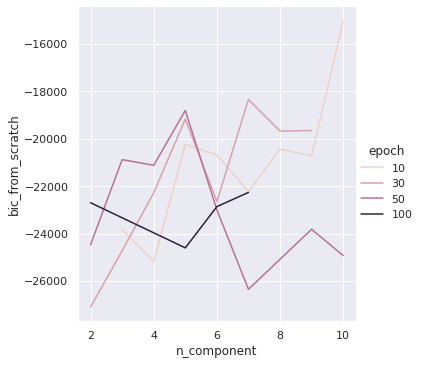

In [22]:
sns.relplot(
    data=df_scratch, 
    kind="line",
    x="n_component", y="aic_from_scratch", 
    hue="epoch"
)

sns.relplot(
    data=df_scratch, 
    kind="line",
    x="n_component", y="bic_from_scratch",
    hue="epoch"
)

In [26]:
df_scratch.sort_values(by=['bic_from_scratch', 'aic_from_scratch'], inplace=True, ascending=False)
df_scratch.head()

,epoch,n_component,aic_from_scratch,bic_from_scratch
8,10,10,-14951.427734,-15029.197266
14,30,7,-18284.490234,-18338.929688
20,50,5,-18764.498047,-18803.382812
12,30,5,-19125.005859,-19163.890625
30,100,10,-19377.001953,-19454.771484


<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



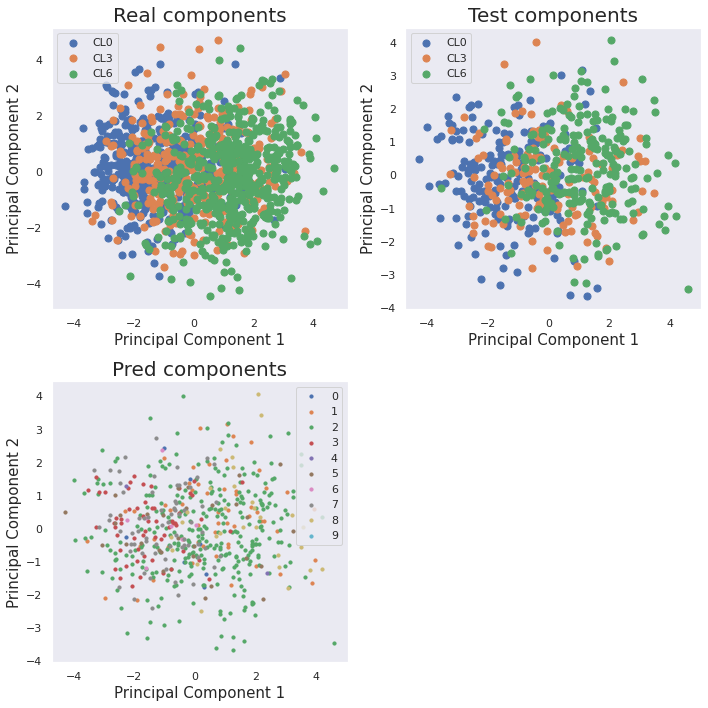

In [27]:
n_components = 10
epoch = 10
model = GaussianMixtureModelNd(n_component, n_epochs=epoch, dim=dim, verbose=False)
model.fit(X_train)
y_pred = model.predict(X_test)
plot_components(model, n_components, X_train, y_train, X_test, y_test, y_pred)

### Nicotine

In [44]:
X_train, y_train, X_test, y_test = train_test_dataset("data/nicotine_preprocessed.csv", 1, 13)

#### Analyze AIC and BIC to choose the best hyperparameters

In [45]:
dim = 12
index = 0
epochs = [10, 30, 50, 10]
components = [2, 3, 4, 5, 6, 7, 8, 9, 10]
epochs_df, aic_from_scratch, bic_from_scratch, aic_sklearn, bic_sklearn, df_components = [], [], [], [], [], []

for epoch in tqdm(epochs):
    for n_component in components:
        
        try:
            model = GaussianMixtureModelNd(n_component, n_epochs=epoch, dim=dim, verbose=False)
            model.fit(X_train)
            aic_from_scratch.append(aic(X_train, model))
            bic_from_scratch.append(bic(X_train, model))

            model = GaussianMixture(n_components=n_component, max_iter=epoch)
            model.fit(X_train)
            aic_sklearn.append(model.aic(X_train))
            bic_sklearn.append(model.bic(X_train))

            epochs_df.append(epoch)
            df_components.append(n_component)
            
        except:
            pass
    

  0%|          | 0/4 [00:00<?, ?it/s]

<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



/home/katarzyna/.local/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



/home/katarzyna/.local/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



/home/katarzyna/.local/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



/home/katarzyna/.local/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



/home/katarzyna/.local/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
 25%|██▌       | 1/4 [01:49<05:29, 109.87s/it]

<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



 50%|█████     | 2/4 [03:39<03:39, 109.74s/it]

<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



 75%|███████▌  | 3/4 [05:26<01:48, 108.96s/it]

<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



/home/katarzyna/.local/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



/home/katarzyna/.local/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



/home/katarzyna/.local/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



/home/katarzyna/.local/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



/home/katarzyna/.local/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)
100%|██████████| 4/4 [07:09<00:00, 107.33s/it]

In [71]:
df = pd.DataFrame()

df["epoch"] = epochs_df
df['n_component'] = df_components
df["aic_from_scratch"] = aic_from_scratch
df["bic_from_scratch"] = bic_from_scratch

df["aic_sklearn"] = aic_sklearn
df["bic_sklearn"] = bic_sklearn

df.to_csv("results/nicotine_gmm.csv")

#### Best parameters for Sklearn

In [72]:
df_sklearn = df
df_sklearn = df_sklearn.drop('aic_from_scratch', axis=1)
df_sklearn = df_sklearn.drop('bic_from_scratch', axis=1)
df_sklearn.head()

,epoch,n_component,aic_sklearn,bic_sklearn
0,10,2,25404.304605,26342.722481
1,10,3,16211.869189,17622.088319
2,10,4,15449.600383,17331.620766
3,10,5,7285.518440,9639.340075
4,10,6,7419.871988,10245.494876


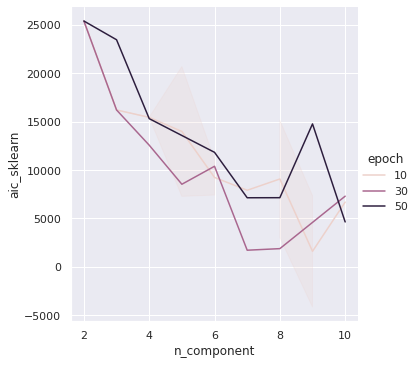

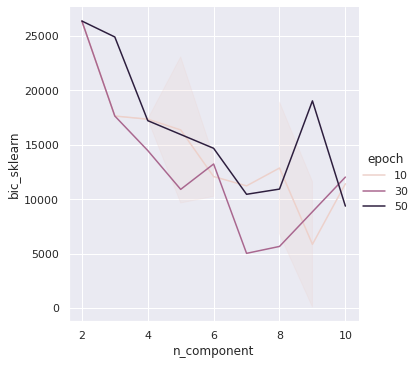

In [73]:
sns.relplot(
    data=df_sklearn, 
    kind="line",
    x="n_component", y="aic_sklearn", 
    hue="epoch"
)

sns.relplot(
    data=df_sklearn, 
    kind="line",
    x="n_component", y="bic_sklearn",
    hue="epoch"
)

In [65]:
df_sklearn.sort_values(by=['bic_sklearn', 'aic_sklearn'], inplace=True, ascending=False)
df_sklearn.head()

,epoch,n_component,aic_sklearn,bic_sklearn
0,10,2,25404.304605,26342.722481
8,30,2,25404.304605,26342.722481
16,50,2,25404.304605,26342.722481
24,10,2,25404.304605,26342.722481
17,50,3,23468.269987,24878.489116


/home/katarzyna/.local/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


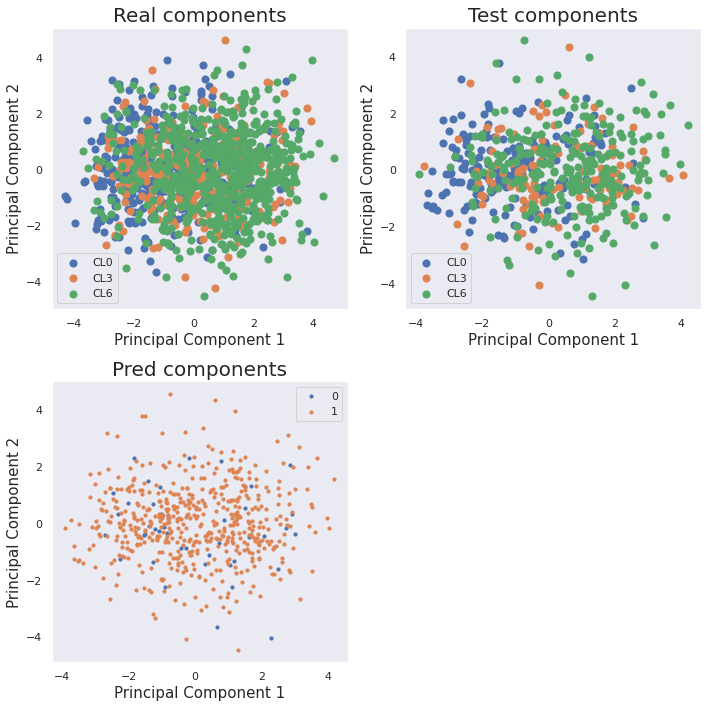

In [74]:
n_components = 2
epoch = 10
model = GaussianMixture(n_components=n_components, max_iter=epoch)
model.fit(X_train)
y_pred = model.predict(X_test)
plot_components(model, n_components, X_train, y_train, X_test, y_test, y_pred)

#### Best model parameters from scratch

In [66]:
df_scratch = df
df_scratch = df_scratch.drop('aic_sklearn', axis=1)
df_scratch = df_scratch.drop('bic_sklearn', axis=1)
df_scratch.head()


,epoch,n_component,aic_from_scratch,bic_from_scratch
0,10,2,-21726.175781,-21741.730469
1,10,3,-24424.113281,-24447.443359
2,10,4,-22971.451172,-23002.558594
3,10,5,-19185.644531,-19224.529297
4,10,6,-25169.570312,-25216.232422


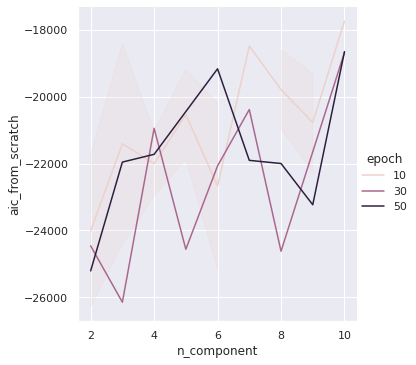

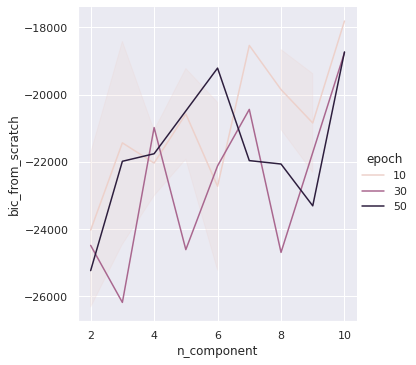

In [60]:
sns.relplot(
    data=df_scratch, 
    kind="line",
    x="n_component", y="aic_from_scratch", 
    hue="epoch"
)

sns.relplot(
    data=df_scratch, 
    kind="line",
    x="n_component", y="bic_from_scratch",
    hue="epoch"
)


In [67]:
df_scratch.sort_values(by=['bic_from_scratch', 'aic_from_scratch'], inplace=True, ascending=False)
df_scratch.head()

,epoch,n_component,aic_from_scratch,bic_from_scratch
7,10,10,-17733.654297,-17811.423828
25,10,3,-18394.828125,-18418.158203
29,10,7,-18482.783203,-18537.222656
5,10,8,-18598.556641,-18660.771484
23,50,10,-18651.873047,-18729.642578


<ipython-input-5-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



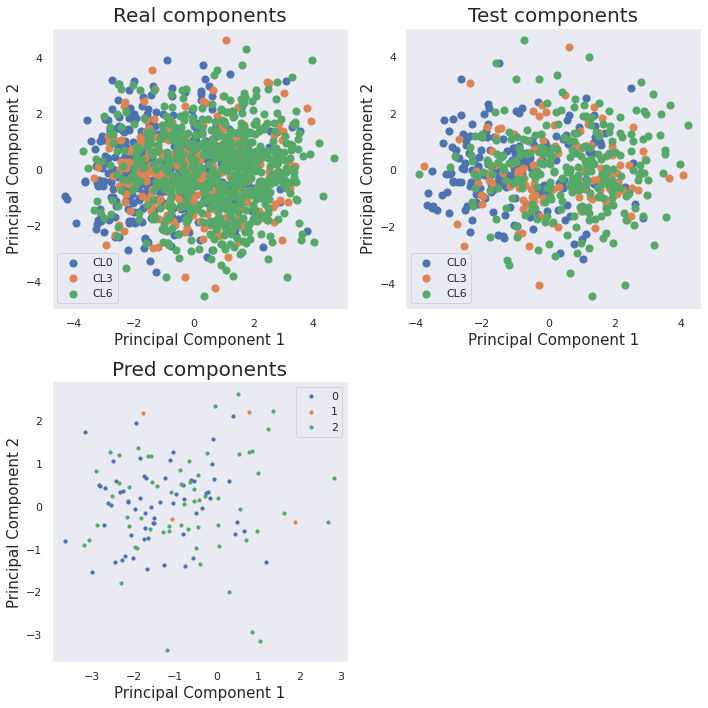

In [69]:
n_components = 3
epoch = 10
model = GaussianMixtureModelNd(n_component, n_epochs=epoch, dim=dim, verbose=False)
model.fit(X_train)
y_pred = model.predict(X_test)
plot_components(model, n_components, X_train, y_train, X_test, y_test, y_pred)

### Test metrics for best hyperparameters

In [51]:
from sklearn.metrics import classification_report

###  Cannabis

In [52]:
X_train, y_train, X_test, y_test = train_test_dataset("data/cannabis_preprocessed.csv", 1, 13)

##### Sklearn

/home/katarzyna/.local/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


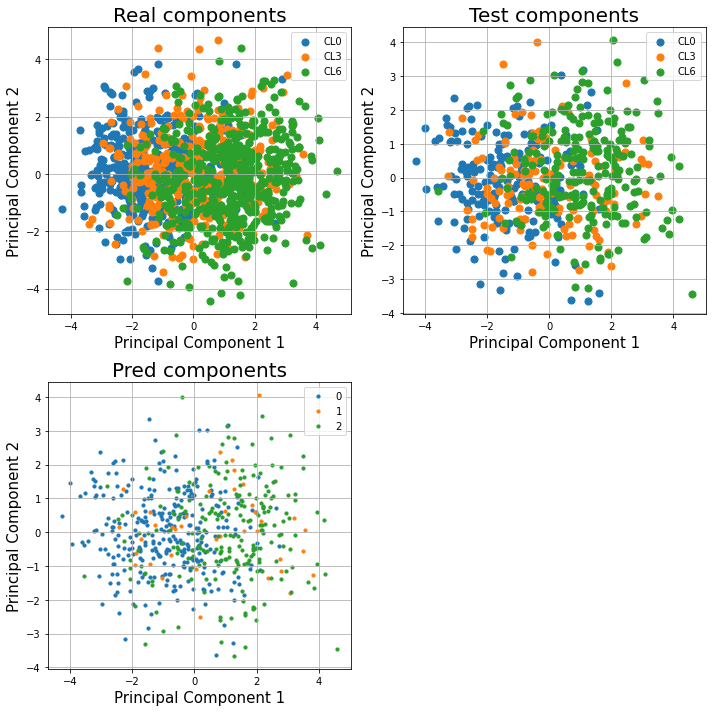

In [53]:
n_components = 3
epoch = 10
model = GaussianMixture(n_components=n_components, max_iter=epoch)
model.fit(X_train)
y_pred = model.predict(X_test)
plot_components(model, n_components, X_train, y_train, X_test, y_test, y_pred)

In [54]:
# 0 -> CL0
# 1 -> CL3
# 2 -> CL6
y = []
for y_n in y_test:
    if y_n == ['CL0']:
        y.append(0)
    elif y_n == ['CL3']:
        y.append(1)
    elif y_n == ['CL6']:
        y.append(2)

In [55]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.78      0.60       186
           1       0.20      0.06      0.09       143
           2       0.66      0.62      0.64       237

    accuracy                           0.53       566
   macro avg       0.45      0.49      0.44       566
weighted avg       0.48      0.53      0.49       566



#### Scratch

<ipython-input-2-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



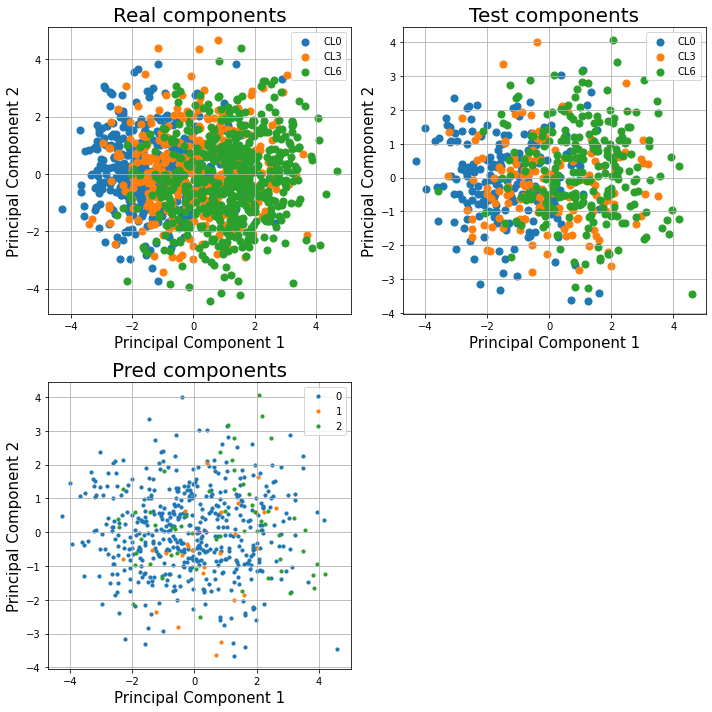

In [59]:
n_component = 3
dim = 12
epoch = 10
model = GaussianMixtureModelNd(n_component, n_epochs=epoch, dim=dim, verbose=False)
model.fit(X_train)
y_pred = model.predict(X_test)
plot_components(model, n_component, X_train, y_train, X_test, y_test, y_pred)

In [60]:
# 0 -> CL0
# 1 -> CL3
# 2 -> CL6
y = []
for y_n in y_test:
    if y_n == ['CL0']:
        y.append(0)
    elif y_n == ['CL3']:
        y.append(1)
    elif y_n == ['CL6']:
        y.append(2)

In [61]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.34      0.89      0.50       186
           1       0.31      0.06      0.09       143
           2       0.54      0.13      0.21       237

    accuracy                           0.36       566
   macro avg       0.40      0.36      0.27       566
weighted avg       0.42      0.36      0.28       566



### Nicotine

In [62]:
X_train, y_train, X_test, y_test = train_test_dataset("data/nicotine_preprocessed.csv", 1, 13)

#### Sklearn

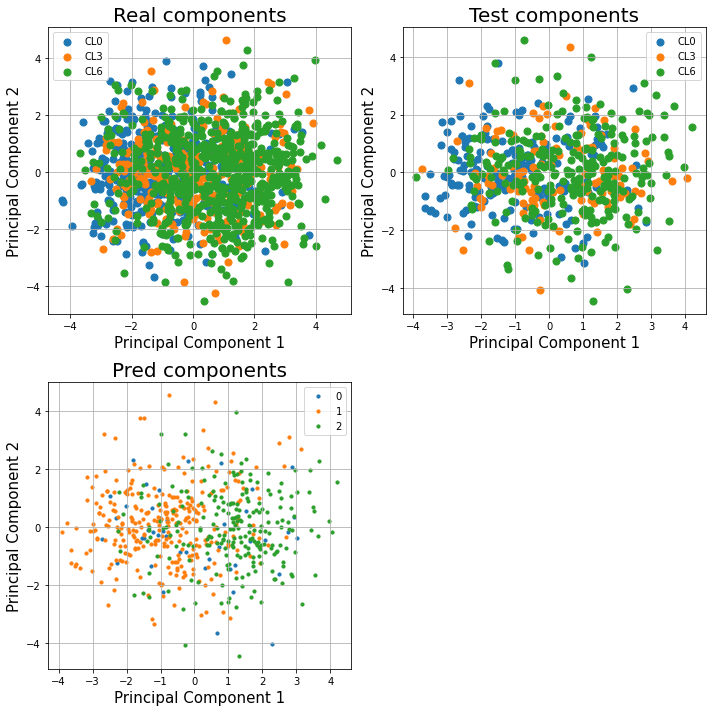

In [63]:
n_components = 3
epoch = 10
model = GaussianMixture(n_components=n_components, max_iter=epoch)
model.fit(X_train)
y_pred = model.predict(X_test)
plot_components(model, n_components, X_train, y_train, X_test, y_test, y_pred)

In [64]:
# 0 -> CL3
# 1 -> CL0
# 2 -> CL6
y = []
for y_n in y_test:
    if y_n == ['CL3']:
        y.append(0)
    elif y_n == ['CL0']:
        y.append(1)
    elif y_n == ['CL6']:
        y.append(2)

In [65]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.21      0.08      0.11       117
           1       0.43      0.69      0.53       186
           2       0.55      0.47      0.51       263

    accuracy                           0.46       566
   macro avg       0.40      0.41      0.38       566
weighted avg       0.44      0.46      0.43       566



#### Scratch

<ipython-input-2-7fded24e02a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resp = torch.tensor(resp, dtype=torch.float32)


Log likelihood not increasing, stopping.



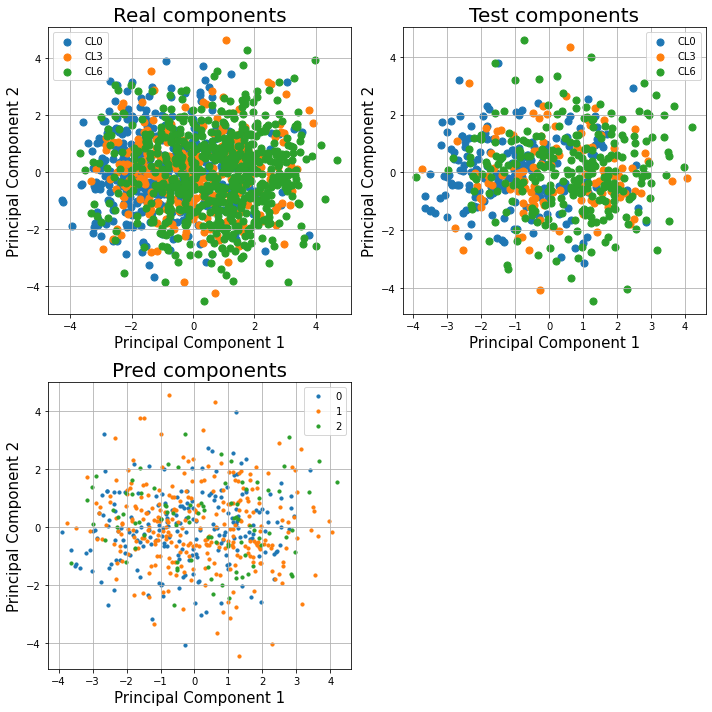

In [69]:
n_component = 3
dim = 12
epoch = 10
model = GaussianMixtureModelNd(n_component, n_epochs=epoch, dim=dim, verbose=False)
model.fit(X_train)
y_pred = model.predict(X_test)
plot_components(model, n_component, X_train, y_train, X_test, y_test, y_pred)

In [70]:
# 0 -> CL0
# 1 -> CL6
# 2 -> CL3
y = []
for y_n in y_test:
    if y_n == ['CL0']:
        y.append(0)
    elif y_n == ['CL6']:
        y.append(1)
    elif y_n == ['CL3']:
        y.append(2)

In [71]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.35      0.39      0.37       186
           1       0.45      0.47      0.46       263
           2       0.11      0.09      0.10       117

    accuracy                           0.36       566
   macro avg       0.31      0.31      0.31       566
weighted avg       0.35      0.36      0.36       566

